# Query the Senator Knowledge Graph

This notebook provides the code for various querying of the senator knowledge graph built in build_graph.ipynb

In [91]:
import pandas as pd
import neo4j
import seaborn as sns
pd.options.display.max_colwidth = 150

In [92]:
driver = neo4j.GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", "senate"))

In [93]:

def run(query):
    data = []
    with driver.session() as session:
        result = session.run(query)
        for record in result:
            data.append(record.data())
    return pd.DataFrame(data)

# Example Queries

## --- Simple Queries ---

### (1) Get all bills Bernie Sanders voted yea on

In [94]:
run("""
MATCH (s:Senator {name: "Bernie Sanders"})-[v:Voted {vote_type: "yea"}]-(r:Rollcall)
RETURN v.vote_type, r.desc, r.bill_number
""")

,v.vote_type,r.desc,r.bill_number
0,yea,"Isabella Casillas Guzman, of California, to be Administrator of the Small Business Administration",PN789
1,yea,"Rohit Chopra, of the District of Columbia, to be Director, Bureau of Consumer Financial Protection for a term of five years",PN116
2,yea,"Sherilyn Peace Garnett, of California, to be United States District Judge for the Central District of California",PN1478
3,yea,"Cynthia Minette Marten, of California, to be Deputy Secretary of Education",PN128
4,yea,"Graham Scott Steele, of California, to be an Assistant Secretary of the Treasury",PN916
...,...,...,...
548,yea,"Marcia Louise Fudge, of Ohio, to be Secretary of Housing and Urban Development",PN786
549,yea,"Jia M. Cobb, of Virginia, to be United States District Judge for the District of Columbia",PN639
550,yea,"Elizabeth de Leon Bhargava, of New York, to be an Assistant Secretary of Housing and Urban Development",PN1521
551,yea,"Ronald Stroman, of the District of Columbia, to be a Governor of the United States Postal Service for a term expiring December 8, 2028",PN245


### (2) Get all of Bernie Sander tweets ordered by likes

In [95]:
run("""
MATCH (s:Senator {name: "Bernie Sanders"})-[tw:Tweeted]->(t:Tweet)
RETURN t.text, t.likes
ORDER BY t.likes DESC
""")

,t.text,t.likes
0,"Let's be clear. Eli Lilly should apologize for increasing the price of insulin by over 1,200% since 1996 to $275 while it costs less than $10 to m...",481505
1,"The people of Brazil have voted for democracy, workers’ rights and environmental sanity. I congratulate @LulaOficial on his hard fought victory a...",180877
2,Progressive candidates had a great election night. I want to thank everyone who got out there and helped make this happen. There will now be more ...,39733
3,"What's going on in this country right now is class warfare. Unfortunately, the wrong side is winning. Our job now is to stand up and take on the g...",25880
4,I do not think the American people should be paying the highest prices on the planet for prescription drugs.,22300
...,...,...
95,RT @BernieSanders: LIVE FROM TEXAS: @GregCasar is a strong progressive who is standing with the working class and when he gets to Congress…,0
96,RT @SBWorkersUnited: RED CUP REBELLION. OVER 100 STARBUCKS STORES ARE ON STRIKE TODAY. #redcuprebellion,0
97,RT @MichelleVforTX: THANK YOU MCALLEN!! ❤️,0
98,RT @MoveOn: Our tour with @BernieSanders and @nextgenamerica kicks off THIS WEEKEND in Reno &amp; Austin!Will you be there to #VoteFightWin?…,0


### (3) Get the amount each senator received in donations from individuals and from pacs (+ plot)

                 name       party  pac_donations  individual_donations
0          Jon Ossoff    democrat            759               5790714
1         Gary Peters    democrat          79000               2496592
2   John Hickenlooper    democrat             85               1980717
3       Maggie Hassan    democrat          71767               1890518
4         Jacky Rosen    democrat          77340               1721008
..                ...         ...            ...                   ...
72         Ben Cardin    democrat         116250                264249
73        Mike Rounds  republican          70500                242808
74       Brian Schatz    democrat         140500                225810
75     Roger Marshall  republican         143300                223436
76     Bernie Sanders       other         112000                 80277

[77 rows x 4 columns]


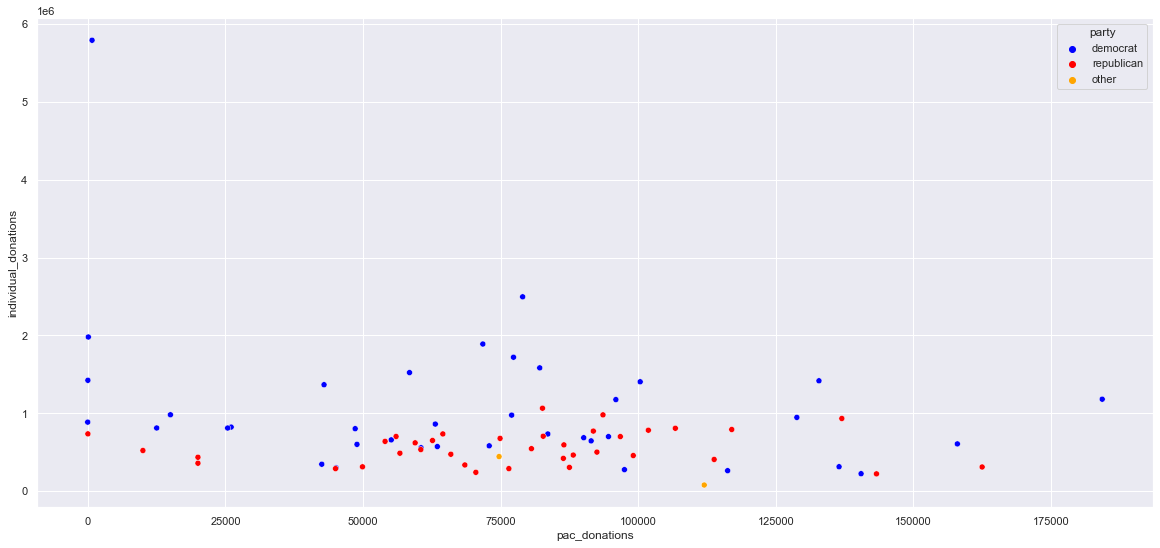

In [96]:
senator_donation_amounts = run("""
MATCH (c:Contributor)-[d:DonatedTo]->(s:Senator)
RETURN s.name as name, s.party as party, sum(d.pac) as pac_donations, sum(d.individual) as individual_donations
ORDER BY sum(d.individual) DESC
""")
print(senator_donation_amounts)


sns.scatterplot(data=senator_donation_amounts, y="individual_donations", x="pac_donations", hue="party", 
    palette=dict(republican="red", democrat="blue", other="orange")
)
sns.set(rc={'figure.figsize':(16, 9)})

## --- Intermediate Level Queries ---

### (4) Get the organization entities mentioned in roll calls for which Bernie Sander voted yea on, and order by organization count 

In [97]:
run("""
MATCH (s:Senator {name: "Bernie Sanders"})-[v:Voted {vote_type: "yea"}]->(r:Rollcall)-[m:Mentions]->(e:Entity {type: "ORG"})
RETURN e.name, count(e)
ORDER BY count(e) DESC
""")

,e.name,count(e)
0,state,18
1,treasury,13
2,defense,12
3,the environmental protection agency,12
4,washington,11
...,...,...
133,medicaid,1
134,the maritime administration,1
135,the national credit union administration board,1
136,administration,1


### (5) Get the organization entities that Bernie Sanders tweets about, and order by organization count

In [98]:
run("""
MATCH (s:Senator {name: "Bernie Sanders"})-[tw:Tweeted]->(t:Tweet)-[m:Mentions]->(e:Entity {type: "ORG"})
RETURN e.name, count(e)
ORDER BY count(e) DESC
""")

,e.name,count(e)
0,congress,13
1,texas,11
2,nevada,3
3,senate,3
4,washington,3
5,house,2
6,social security,2
7,starbucks,2
8,@summerforpa,2
9,the u.s. house,2


### (6) Get the event entities that Republicans tweet about, and order by the event count

In [99]:
run("""
MATCH (s:Senator {party: "republican"})-[tw:Tweeted]->(t:Tweet)-[m:Mentions]->(e:Entity {type: "EVENT"})
RETURN e.name, count(e)
ORDER BY count(e) DESC
""")

,e.name,count(e)
0,covid,22
1,veterans day,17
2,election day,15
3,halloween,15
4,#,11
...,...,...
273,alconv2022,1
274,general session,1
275,oktoberfest,1
276,#veteransday quite like,1


### (7) Get total contributions and total tweet likes per senator (+ plot)

                name  donation_totals       party  tweet_likes
0        Mitt Romney         67813200  republican     22513950
1     Bernie Sanders         19227700       other     20708720
2   Marsha Blackburn        107143100  republican     10153120
3        Marco Rubio         71373542  republican      7192900
4   Elizabeth Warren         85030800    democrat      6564280
..               ...              ...         ...          ...
71    Jeanne Shaheen         84383046    democrat        40280
72      John Boozman         66459381  republican        38100
73        Mike Crapo         62119332  republican        36220
74      Bill Cassidy         58420250  republican        25380
75       John Hoeven         36378200  republican        24220

[76 rows x 4 columns]


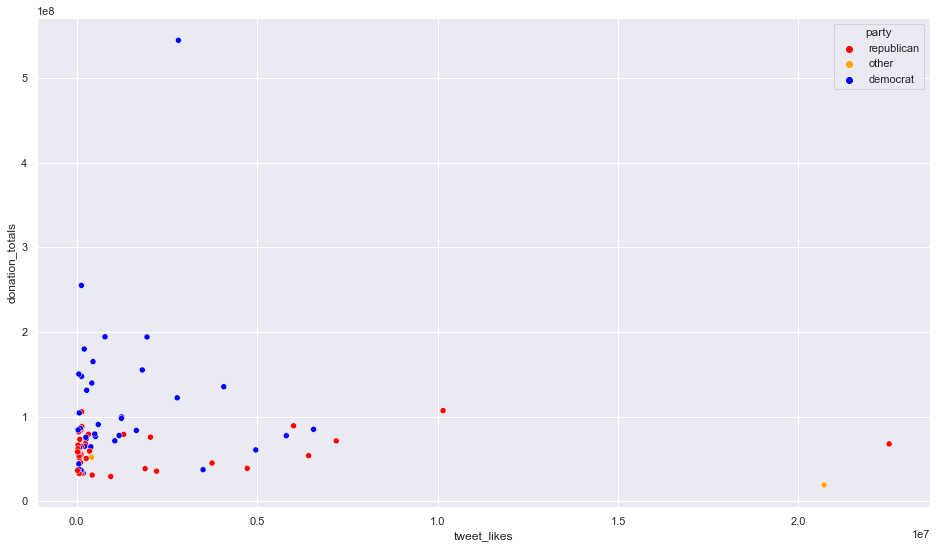

In [100]:
senator_donation_likes = run("""
MATCH (c:Contributor)-[d:DonatedTo]->(s:Senator)-[tw:Tweeted]->(t:Tweet)
RETURN s.name as name, sum(d.total) as donation_totals, s.party as party, sum(t.likes) as tweet_likes
ORDER BY sum(t.likes) DESC
""")
print(senator_donation_likes)
sns.scatterplot(
    data=senator_donation_likes, x="tweet_likes", y="donation_totals", hue="party", 
    palette=dict(republican="red", democrat="blue", other="orange")
)
sns.set(rc={'figure.figsize':(20, 9)})

### (8) Get the senators that have been tweeting about covid the most

In [ ]:
run("""
MATCH (s:Senator)-->(t:Tweet)
WHERE toLower(t.text) CONTAINS "covid"
RETURN s.name, s.party, count(s)
ORDER BY count(s) desc
""")

## --- More Advanced Queries ---

### (9) Get the contributers who supported Senators that voted yes on bills mentioning 'the environmental protection agency'. Return the contributor, senator, and the amount.

In [111]:
run("""
MATCH (s:Senator)-[v:Voted {vote_type: "yea"}]->(r:Rollcall)-[m:Mentions]->(e:Entity {name: "the environmental protection agency"})
WITH s
MATCH (c:Contributor)-[d:DonatedTo]->(s)
RETURN c.name as contributor, sum(d.total) as amount, s.name as senator
ORDER BY sum(d.total) DESC
""")

,contributor,amount,senator
0,alphabet inc,13015272,Jon Ossoff
1,university of california,8661852,Jon Ossoff
2,emily's list,7250628,Jacky Rosen
3,league of conservation voters,7179830,Jon Tester
4,university of michigan,5435280,Gary Peters
...,...,...,...
1546,citizens united,20000,Cynthia Lummis
1547,credit union national assn,20000,Cynthia Lummis
1548,alamo pac,20000,Cynthia Lummis
1549,freedom fund,20000,Cynthia Lummis


In [104]:
### (10) Find the percentage of donations for each candidate that come from universities

In [105]:
run("""
MATCH (c:Contributor)-[d:DonatedTo]->(s:Senator)
WHERE toLower(c.name) CONTAINS "university"
WITH s, sum(d.total) as university_donations

MATCH (c:Contributor)-[d:DonatedTo]->(s)
RETURN s.name, s.party, s.state, toFloat(university_donations) / toFloat(sum(d.total)) as university_percentage

ORDER BY university_percentage DESC
""")

,s.name,s.party,s.state,university_percentage
0,Gary Peters,democrat,MI,0.372539
1,Mark Kelly,democrat,AZ,0.337904
2,John Hickenlooper,democrat,CO,0.282697
3,Jon Ossoff,democrat,GA,0.256810
4,Tammy Baldwin,democrat,WI,0.252449
5,Ed Markey,democrat,MA,0.247207
6,Sherrod Brown,democrat,OH,0.226102
7,Jeff Merkley,democrat,OR,0.215938
8,Bernie Sanders,other,VT,0.196612
9,Elizabeth Warren,democrat,MA,0.187580


### (11) Of the above senators, have any tweeted about student loans? 

In [106]:
run("""
MATCH (c:Contributor)-[d:DonatedTo]->(s:Senator)
WHERE toLower(c.name) CONTAINS "university"
WITH s, sum(d.total) as university_donations

MATCH (c:Contributor)-[d:DonatedTo]->(s)
WITH s, toFloat(university_donations) / toFloat(sum(d.total)) as university_percentage

MATCH (s:Senator)-[tw:Tweeted]->(t:Tweet)
WHERE toLower(t.text) CONTAINS "student loan"
RETURN s.name, university_percentage, t.text, t.likes

ORDER BY university_percentage DESC
""")

,s.name,university_percentage,t.text,t.likes
0,Ed Markey,0.247207,The limited Public Student Loan Forgiveness waiver deadline is in less than 2 weeks. In addition to applying for loan forgiveness—don’t forget to ...,14
1,Debbie Stabenow,0.125328,ICYMI: The application for student loan debt relief is now live! It only takes a few minutes!,32
2,Martin Heinrich,0.090564,"The Federal Student Loan Debt Relief Application is live. New Mexicans can apply for up to $20,000 in debt relief by visiting",9
3,Patty Murray,0.076407,Reminder: you have until October 31 to apply for Public Service Loan Forgiveness under the temporary waiver.Whether you're a teacher in Walla Wall...,113
4,Patty Murray,0.076407,"Every single student deserves a quality education—that's the bottom line.Whether it's getting more resources to K-12 schools across WA state, incr...",373
5,Patty Murray,0.076407,"You can now apply for @POTUS's student loan debt relief program!This is huge—borrowers across Washington state may be eligible for up to $20,000 i...",262
6,Dick Durbin,0.065033,"For years, Americans struggling w/ student loan debt have been effectively unable to use the bankruptcy system to seek a path to financial recover...",183
7,Tommy Tuberville,0.039209,"RT @cnsnews: .@SenTuberville says Joe Biden has ""no"" authority to forgive student loan debts, adding it's ""not constitutional.""",0
8,Tommy Tuberville,0.039209,With the economy heading straight into a recession @POTUS has decided to take tax dollars from everyday Americans and forgive student loans.It’s c...,106


### (12) Of democratic senators who frequently cross the aisle, who are their most popular donors?
### * defined as voting on a bill the majority of republicans voted on and fewer than 5 other democrats voted on, more than 10 times

In [107]:
run("""
MATCH (rs:Senator {party:"republican"})-[rv:Voted {vote_type: "yea"}]->(r:Rollcall)
with r, count(rv) as republican_votes
MATCH (ds:Senator {party:"democrat"})-[dv:Voted {vote_type: "yea"}]->(r:Rollcall)
with r, count(dv) as democrat_votes, republican_votes
WHERE republican_votes > 21 and democrat_votes < 5

MATCH (ds:Senator {party:"democrat"})-[dv:Voted {vote_type: "yea"}]->(r:Rollcall)
WITH ds as democrat_aisle_crosser, count(ds) as dissenting_votes
WHERE count(ds) > 10

MATCH (c:Contributor)-[d:DonatedTo]->(democrat_aisle_crosser)
RETURN c.name, sum(d.total)
ORDER BY sum(d.total) DESC
""")

,c.name,sum(d.total)
0,democracy engine,245011
1,university of california,162838
2,alphabet inc,110153
3,university of arizona,101501
4,west virginia state democratic exec cmte,100000
5,arizona state university,94369
6,capital group,86400
7,mylan inc,80425
8,microsoft corp,69500
9,apple inc,66909


### Compare that to the top contributors among all democrats

In [108]:
run("""
MATCH (c:Contributor)-[d:DonatedTo]->(ds:Senator {party:"democrat"})
RETURN c.name, sum(d.total)
ORDER BY sum(d.total) DESC
""")

,c.name,sum(d.total)
0,democracy engine,2907936
1,emily's list,2612561
2,alphabet inc,1945938
3,league of conservation voters,1630684
4,university of california,1403997
...,...,...
389,chugach native assn,10250
390,national assn of letter carriers,10160
391,giddy up pac,10000
392,common sense colorado,10000


### (13) Of all senators who received donations from contributors with "oil" in the name, how did they vote on keystone xl?

In [109]:
run("""
match (c:Contributor)-[d:DonatedTo]->(s:Senator)-[v:Voted]->(r:Rollcall)    
where toLower(c.name) contains "oil" and toLower(r.desc) contains "keystone xl"
return s.name, sum(d.total) as oil_donations, v.vote_type
order by sum(d.total) desc
""")

,s.name,oil_donations,v.vote_type
0,Kevin Cramer,53000,yea
1,Roger Wicker,43200,yea
2,Mike Braun,43200,yea
3,Bill Cassidy,36600,yea
4,Cindy Hyde-Smith,33600,yea
5,Tom Cotton,31750,yea
6,Jerry Moran,29506,yea
7,John Hoeven,29506,yea
8,Chuck Grassley,29506,yea
9,James Lankford,29506,yea


### (14) Of the above senators, do any have tweets mentioning oil?

In [110]:
run("""
match (c:Contributor)-[d:DonatedTo]->(s:Senator)-->(t:Tweet)
match (s)-[v:Voted]->(r:Rollcall)    
where toLower(c.name) contains "oil" and toLower(t.text) contains " oil" and toLower(r.desc) contains "keystone xl" 
return s.name, sum(d.total) as oil_donations, v.vote_type, t.text
order by sum(d.total) desc
""")

,s.name,oil_donations,v.vote_type,t.text
0,Kevin Cramer,53000,yea,Did @JoeBiden just say he’d get to zero emissions by 2025. And how does he plan to allow fracking while eliminating oil? Go @realDonaldTrump #Deba...
1,Bill Cassidy,36600,yea,Don’t miss my interview on @KPLC7News! I sat down with Rhonda Hardin to discuss Biden’s handling of the Oil and Gas industry. Watch Below↓
2,Bill Cassidy,36600,yea,"The only solution to the growing oil crisis is domestic production, but Biden refuses to accept this.Read more ↓"
3,Bill Cassidy,36600,yea,Outrage of the Week:Biden’s oil policies are disastrous! He is cutting off our own natural supply and NOT acting in the interest of the American p...
4,Bill Cassidy,36600,yea,Biden’s tax and spending spree are only driving up prices at the pump by putting MORE taxes on crude oil! Watch below to watch my interview on @Fo...
5,Cindy Hyde-Smith,33600,yea,President @JoeBiden's fear of angering his radical Green New Deal supporters is causing him to drain our oil reserves rather than unleash American...
6,Cindy Hyde-Smith,33600,yea,"Hey, remember when Republicans tried to fill up the SPR (even before it was this dangerously low) while oil was $27 per barrel and @SenSchumer blo..."
7,Cindy Hyde-Smith,33600,yea,"President @JoeBiden stifled U.S. energy production &amp; sent energy prices soaring. Instead of increasing our production to ease prices, @POTUS b..."
8,Cindy Hyde-Smith,33600,yea,"You’ve got to be kidding. @JoeBiden gets shut down by Putin and Putin’s buddies, so he turns to Venezuela to beg for more oil. He would actually r..."
9,Cindy Hyde-Smith,33600,yea,"It was disheartening to watch our President beg OPEC+ to not cut oil production, rather than increase our own. OPEC making cuts anyway. Now Americ..."
